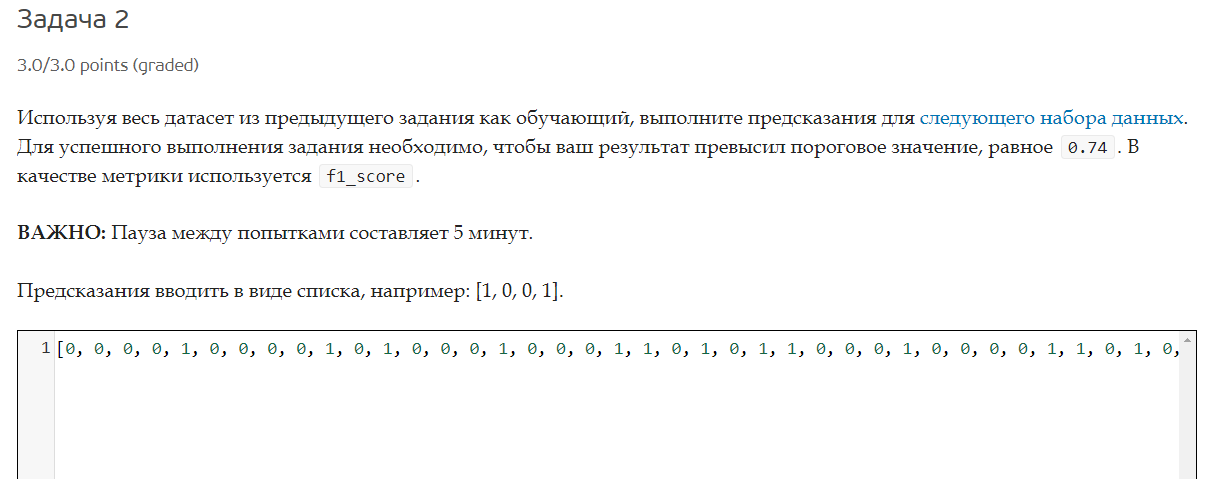

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
from sklearn.linear_model import LogisticRegression

# Читаем
data_train = pd.read_csv('Data/titanic_train.csv')
data_reserved = pd.read_csv('Data/titanic_reserved.csv')


# очищаем признаки с кол-вом пропусков больше 1/3
print(data_train.isnull().sum()/len(data_train))
columns_to_drop = ['cabin','home.dest','ticket']
df_train_droped = data_train.drop(columns_to_drop, axis=1)
df_test_droped = data_reserved.drop(columns_to_drop, axis=1)

# Замена 2-х столбцов на 1 суммирующий
df_train_droped['fam_size'] = df_train_droped['sibsp'] + df_train_droped['parch']
df_train_droped = df_train_droped.drop(columns=['sibsp', 'parch'])
df_test_droped['fam_size'] = df_test_droped['sibsp'] + df_test_droped['parch']
df_test_droped = df_test_droped.drop(columns=['sibsp', 'parch'])

# Заполняем пропуски на основе обращений
df_train_droped['honorific'] = list(df_train_droped['name'].str.extract('([A-Za-z]+)\.')[0])
df_test_droped['honorific'] = list(df_test_droped['name'].str.extract('([A-Za-z]+)\.')[0])
#print(pd.crosstab(df_test_droped['sex'], df_test_droped['honorific']))
print('Число уникальных honorific в train:', len(df_train_droped['honorific'].unique()))
print(df_train_droped['honorific'].unique())
print('Число уникальных honorific в test:', len(df_test_droped['honorific'].unique()))
print(df_test_droped['honorific'].unique())


df_train_droped['honorific'].\
replace(['Mlle', 'Rev', 'Ms', 'Col', 'Dona', 'Dr', 'Countess', 'Major', 'Don', 'Capt', 'Lady', 'Jonkheer'],\
        ['Miss', 'Mr', 'Miss', 'Mr', 'Mrs', 'Mr', 'Mrs', 'Mr', 'Mr', 'Mr', 'Mrs', 'Mr'], inplace=True)
df_test_droped['honorific'].\
replace(['Mlle', 'Rev', 'Ms', 'Col', 'Dona', 'Dr', 'Countess', 'Major', 'Don', 'Capt', 'Lady', 'Jonkheer'],\
        ['Miss', 'Mr', 'Miss', 'Mr', 'Mrs', 'Mr', 'Mrs', 'Mr', 'Mr', 'Mr', 'Mrs', 'Mr'], inplace=True)


df_train_droped.loc[(df_train_droped['age'].isnull()) & (df_train_droped['honorific'] == 'Master'), 'age'] = dict(df_train_droped.groupby('honorific')['age'].mean())['Master']
df_train_droped.loc[(df_train_droped['age'].isnull()) & (df_train_droped['honorific'] == 'Miss'), 'age'] = dict(df_train_droped.groupby('honorific')['age'].mean())['Miss']
df_train_droped.loc[(df_train_droped['age'].isnull()) & (df_train_droped['honorific'] == 'Mr'), 'age'] = dict(df_train_droped.groupby('honorific')['age'].mean())['Mr']
df_train_droped.loc[(df_train_droped['age'].isnull()) & (df_train_droped['honorific'] == 'Mrs'), 'age'] = dict(df_train_droped.groupby('honorific')['age'].mean())['Mrs']

df_test_droped.loc[(df_test_droped['age'].isnull()) & (df_test_droped['honorific'] == 'Master'), 'age'] = dict(df_test_droped.groupby('honorific')['age'].mean())['Master']
df_test_droped.loc[(df_test_droped['age'].isnull()) & (df_test_droped['honorific'] == 'Miss'), 'age'] = dict(df_test_droped.groupby('honorific')['age'].mean())['Miss']
df_test_droped.loc[(df_test_droped['age'].isnull()) & (df_test_droped['honorific'] == 'Mr'), 'age'] = dict(df_test_droped.groupby('honorific')['age'].mean())['Mr']
df_test_droped.loc[(df_test_droped['age'].isnull()) & (df_test_droped['honorific'] == 'Mrs'), 'age'] = dict(df_test_droped.groupby('honorific')['age'].mean())['Mrs']

df_train_droped = df_train_droped.drop(columns=['name', 'honorific'])
df_test_droped = df_test_droped.drop(columns=['name', 'honorific'])

# разделяем на предикторы и отклик
Y_train = df_train_droped[['survived']]
X_train = df_train_droped.drop(['survived'], axis=1)
#Y_test = data_reserved_cleaned[['label']]
#X_test = data_reserved_cleaned.drop(['label'], axis=1)
X_test = df_test_droped.copy()




# разделяем на категориальные и метрические предикторы
mask = X_train.dtypes.values==object

x_train_mask = X_train[X_train.columns[mask]] # категориальные признаки
x_train_not_mask = X_train[X_train.columns[~mask]] # некатегориальные признаки
x_test_mask = X_test[X_test.columns[mask]]
x_test_not_mask = X_test[X_test.columns[~mask]]



# модификация категориальных признаков
te = ce.target_encoder.TargetEncoder(cols=x_train_mask.columns)
x_train_mask_ce = te.fit_transform(x_train_mask, Y_train)
x_train_mask_ce_final = pd.concat([x_train_mask_ce, x_train_not_mask], axis=1)
x_test_mask_ce = te.transform(x_test_mask)
x_test_mask_ce_final = pd.concat([x_test_mask_ce, x_test_not_mask], axis=1)


# масштабируем разбиваем обучаем и оцениваем
# масштабируем
scaler = MinMaxScaler()
#x_final_dum_scaled = pd.DataFrame(scaler.fit_transform(x_final_dum), columns=x_final_dum.columns)
x_train_mask_ce_final_scaled = pd.DataFrame(scaler.fit_transform(x_train_mask_ce_final), columns=x_train_mask_ce_final.columns)
x_test_mask_ce_final_scaled = pd.DataFrame(scaler.transform(x_test_mask_ce_final), columns=x_test_mask_ce_final.columns)


model = LogisticRegression(random_state=9, max_iter=1000).fit(x_train_mask_ce_final_scaled, Y_train)
predictions = model.predict(x_test_mask_ce_final_scaled)
print(predictions.tolist())
